**Import all necessary files and Waffer Dataset**

In [2]:
import os, json, math, time, random
from glob import glob
from collections import Counter, defaultdict

import numpy as np
from PIL import Image
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from skimage.transform import rescale, rotate
from skimage.morphology import opening, disk
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Config (edit here)
# -----------------------------
DATA_DIR = "/kaggle/input/wm811k-silicon-wafer-map-dataset-image/WM811k_Dataset"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

**Dataset Preprocessing for Model Training**

In [3]:
CLASS_NAMES = sorted(os.listdir(DATA_DIR))
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}


class WM811kDataset(Dataset):
    def __init__(self, root, transform=None, use_pvm=True):
        self.samples = []
        self.transform = transform
        self.use_pvm = use_pvm

        for cls in CLASS_NAMES:
            cls_dir = os.path.join(root, cls)
            for f in os.listdir(cls_dir):
                if f.endswith(".png") or f.endswith(".jpg"):
                    self.samples.append(
                        (os.path.join(cls_dir, f), CLASS_TO_IDX[cls])
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        # Load FULL resolution wafer
        img = Image.open(path).convert("L")
        wafer_np = np.array(img)

        # TEMP debug (remove after first successful run)
        # print("Raw wafer shape:", wafer_np.shape)

        if self.use_pvm:
            core, _, conf, _ = wafer_pvm_full(wafer_np)
        else:
            core = np.zeros_like(wafer_np)
            conf = np.zeros_like(wafer_np)

        # Convert to torch (still full-res)
        wafer = torch.tensor(wafer_np).float().unsqueeze(0)
        core = torch.tensor(core).float().unsqueeze(0)
        conf = torch.tensor(conf).float().unsqueeze(0)

        # Resize AFTER PVM
        wafer = torch.nn.functional.interpolate(wafer[None], size=(224, 224), mode="bilinear", align_corners=False)[0]
        core = torch.nn.functional.interpolate(core[None], size=(224, 224), mode="nearest")[0]
        conf = torch.nn.functional.interpolate(conf[None], size=(224, 224), mode="bilinear", align_corners=False)[0]

        # Stack into 3-channel tensor
        wafer = torch.cat([wafer, core, conf], dim=0)

        return wafer, label


**Wafer-Pyramid Voting Module**

Core pixels: 15
Regions: [(105, 151, 108, 154), (110, 150, 113, 153), (111, 141, 114, 144)]


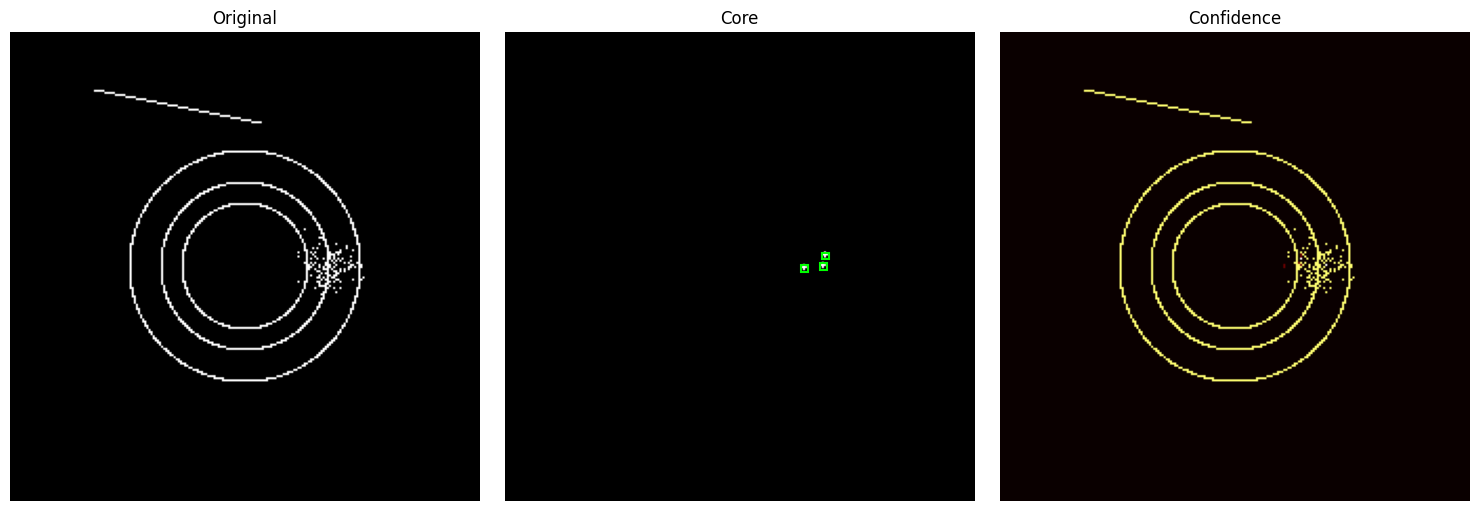

In [4]:
# ======================
# Transforms
# ======================

TRANSFORMS = [
    ("id", None),
    ("r90", None),
    ("r180", None),
    ("r270", None),
    ("fh", None),
    ("fv", None),
    ("s08", 0.8),
]


def apply_transform(img, spec):
    name, param = spec
    if name == "id":
        return img.copy()
    if name == "r90":
        return np.rot90(img, 1)
    if name == "r180":
        return np.rot90(img, 2)
    if name == "r270":
        return np.rot90(img, 3)
    if name == "fh":
        return np.fliplr(img)
    if name == "fv":
        return np.flipud(img)
    if name == "s08":
        scale = param
        h, w = img.shape
        small = rescale(img, scale, preserve_range=True, anti_aliasing=False).astype(img.dtype)
        sh, sw = small.shape
        out = np.zeros_like(img)
        ys = (h - sh) // 2
        xs = (w - sw) // 2
        out[ys:ys+sh, xs:xs+sw] = small
        return out
    raise ValueError


def inverse_transform(mask, spec, shape):
    name, _ = spec
    if name == "id":
        return mask.copy()
    if name == "r90":
        return np.rot90(mask, -1)
    if name == "r180":
        return np.rot90(mask, -2)
    if name == "r270":
        return np.rot90(mask, -3)
    if name == "fh":
        return np.fliplr(mask)
    if name == "fv":
        return np.flipud(mask)
    if name == "s08":
        return mask.copy()


# ======================
# Core PVM
# ======================

def preprocess(wafer):
    t = wafer.mean() + wafer.std()
    return (wafer > t).astype(np.uint8)


def dbscan_detect(binary, eps=8, min_samples=1):
    ys, xs = np.where(binary > 0)
    if len(xs) == 0:
        return np.zeros_like(binary)

    pts = np.stack([xs, ys], axis=1)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit(pts).labels_

    mask = np.zeros_like(binary)
    good = labels != -1
    if np.any(good):
        mask[ys[good], xs[good]] = 1
    return mask


def multiview_masks(wafer, transforms, eps, min_samples):
    H, W = wafer.shape
    masks = []

    for spec in transforms:
        t = apply_transform(wafer, spec)
        m = dbscan_detect(t, eps, min_samples)
        m = inverse_transform(m, spec, (H, W))
        masks.append(m)

    return np.stack(masks)


def pixel_voting(stack, vote_ratio=0.3, morph_radius=1):
    votes = stack.sum(0)
    V = stack.shape[0]

    thresh = int(np.ceil(V * vote_ratio))
    core = (votes >= thresh).astype(np.uint8)

    if morph_radius >= 1:
        core = opening(core, disk(int(morph_radius)))

    confidence = votes / float(V)
    return core, confidence


def extract_regions(core, min_area=5):
    lbl = label(core)
    boxes = []
    for r in regionprops(lbl):
        if r.area >= min_area:
            boxes.append(r.bbox)
    return boxes


def wafer_pvm_full(
    wafer,
    transforms=TRANSFORMS,
    eps=8,
    min_samples=1,
    vote_ratio=0.3,
    morph_radius=1,
    min_area=5
):
    w = preprocess(wafer)
    stack = multiview_masks(w, transforms, eps, min_samples)
    core, conf = pixel_voting(stack, vote_ratio, morph_radius)
    regions = extract_regions(core, min_area)
    return core, regions, conf, {"votes": stack.sum(0)}


# ======================
# Utils
# ======================

def visualize(wafer, core, conf, regions=None):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    axs[0].imshow(wafer, cmap="gray")
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(core, cmap="gray")
    axs[1].set_title("Core")
    axs[1].axis("off")

    axs[2].imshow(conf, cmap="hot")
    axs[2].set_title("Confidence")
    axs[2].axis("off")

    # Draw bounding boxes on core
    if regions:
        for (minr,minc,maxr,maxc) in regions:
            rect = plt.Rectangle(
                (minc, minr),
                maxc-minc,
                maxr-minr,
                edgecolor="lime",
                facecolor="none",
                linewidth=1.5
            )
            axs[1].add_patch(rect)

    plt.tight_layout()
    plt.show()



def make_synthetic(H=224,W=224):
    img=np.zeros((H,W),np.uint8)
    cx=W//2; cy=H//2

    for r in [30,40,55]:
        t=np.linspace(0,2*np.pi,720)
        xs=(cx+r*np.cos(t)).astype(int)
        ys=(cy+r*np.sin(t)).astype(int)
        img[ys,xs]=1

    for _ in range(150):
        img[int(cy+np.random.randn()*6),int(cx+40+np.random.randn()*6)]=1

    for x in range(40,120):
        y=int(20+0.2*x)
        img[y,x]=1

    return img


# ======================
# Test
# ======================

if __name__=="__main__":
    wafer = make_synthetic()

    core, regions, conf, _ = wafer_pvm_full(wafer)

    print("Core pixels:", core.sum())
    print("Regions:", regions)

    visualize(wafer, core, conf, regions)


In [6]:
for i in range(len(dataset)):
    w,l = dataset[i]
    if w[0].sum() > 200:   # enough defect pixels
        wafer, lbl = w,l
        print("Using index:", i)
        print("Original sum:", wafer[0].sum().item())
        break



Using index: 0
Original sum: 4971687.0


**Dataset after Wafer-PVM(Pyramid voting Module)**

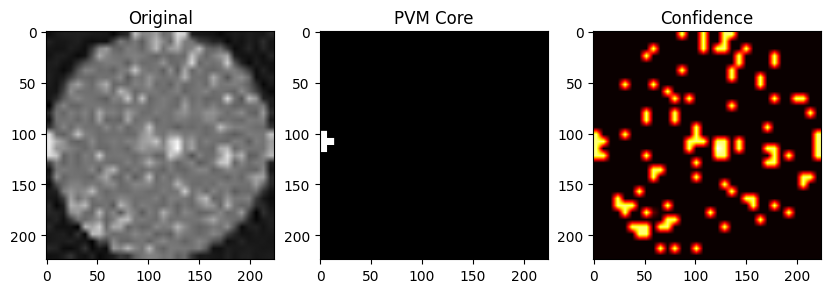

Label: Center


In [5]:
dataset = WM811kDataset(DATA_DIR, use_pvm=True)

wafer, lbl = dataset[0]

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(wafer[0], cmap="gray")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(wafer[1], cmap="gray")
plt.title("PVM Core")

plt.subplot(1,3,3)
plt.imshow(wafer[2], cmap="hot")
plt.title("Confidence")

plt.show()

print("Label:", IDX_TO_CLASS[lbl])


**Survived wafer Images after wafer-PVM(Part-1)**

In [7]:
survived = 0
total = len(dataset)

for i in tqdm(range(total)):
    wafer, _ = dataset[i]

    core = wafer[1]   # channel 1 = core

    if core.sum() > 0:
        survived += 1

print("Total wafers:", total)
print("Survived wafers:", survived)
print("Survival rate:", survived/total)


100%|██████████| 902/902 [00:16<00:00, 53.94it/s]

Total wafers: 902
Survived wafers: 719
Survival rate: 0.7971175166297118


**Purified indices**

In [10]:
alive_indices = []

for i in tqdm(range(len(dataset))):
    wafer, _ = dataset[i]
    if wafer[1].sum() > 0:     # core non-empty
        alive_indices.append(i)

print("Alive:", len(alive_indices))


100%|██████████| 902/902 [00:13<00:00, 65.58it/s] 

Alive: 719


In [13]:
filtered_dataset = Subset(dataset, alive_indices)

In [15]:
train_loader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

**Encoder Module**

In [9]:
class WaferEncoder(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()

        base = models.resnet18(weights="IMAGENET1K_V1")

        # first conv already expects 3 channels, so fine

        self.backbone = nn.Sequential(*list(base.children())[:-1])  # remove FC
        self.fc = nn.Linear(512, emb_dim)

    def forward(self, x):
        x = self.backbone(x)     # [B,512,1,1]
        x = x.flatten(1)
        z = self.fc(x)
        return z


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = WaferEncoder(emb_dim=128).to(device)

classifier = nn.Linear(128, len(CLASS_NAMES)).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(classifier.parameters()),
    lr=1e-3
)

criterion = nn.CrossEntropyLoss(reduction="none")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s] 


In [39]:
model.eval()


WaferEncoder(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [33]:
for epoch in range(100):
    total=0
    for z,y in loader:
        z,y=z.to(device),y.to(device)
        out=clf(z)
        loss=loss_fn(out,y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total+=loss.item()

    print("epoch",epoch,"loss",total/len(loader))


epoch 0 loss 1.769569863875707
epoch 1 loss 1.1053722749153774
epoch 2 loss 0.6437831372022629
epoch 3 loss 0.4492948514719804
epoch 4 loss 0.3793104564150174
epoch 5 loss 0.3408037417878707
epoch 6 loss 0.2905800547450781
epoch 7 loss 0.2902843840420246
epoch 8 loss 0.30323078980048496
epoch 9 loss 0.24667336915930113
epoch 10 loss 0.2364458783219258
epoch 11 loss 0.2300921566784382
epoch 12 loss 0.22881500547130904
epoch 13 loss 0.21589020577569804
epoch 14 loss 0.22707153235872587
epoch 15 loss 0.21875359738866487
epoch 16 loss 0.20519063559671244
epoch 17 loss 0.1986659038811922
epoch 18 loss 0.19155860568086305
epoch 19 loss 0.20328948025902113
epoch 20 loss 0.18506435180703798
epoch 21 loss 0.19376282766461372
epoch 22 loss 0.17780161338547865
epoch 23 loss 0.17358515473703542
epoch 24 loss 0.18263224512338638
epoch 25 loss 0.16964386869221926
epoch 26 loss 0.1672313374777635
epoch 27 loss 0.19765803838769594
epoch 28 loss 0.18656079471111298
epoch 29 loss 0.16446091576168934
epo

**Embeddings are Collected**

In [18]:
model.eval()

embeddings = []
labels_all = []

with torch.no_grad():
    for wafers, labels in train_loader:
        wafers = wafers.to(device)
        z = model(wafers)

        embeddings.append(z.cpu().numpy())
        labels_all.append(labels.numpy())

embeddings = np.concatenate(embeddings)
labels_all = np.concatenate(labels_all)

print("Embedding shape:", embeddings.shape)


Embedding shape: (719, 128)


In [19]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(embeddings)


In [22]:
X = StandardScaler().fit_transform(embeddings)

print(X.min(), X.max(), X.std())


-4.709154 4.6559997 1.0


**DBSCAN is used to generate clusters**

In [23]:
for eps in [3.0,2.5,2.0,1.5,1.2,1.0,0.8,0.6,0.4]:
    db = DBSCAN(eps=eps, min_samples=3)
    c = db.fit_predict(X)
    u,cnt = np.unique(c, return_counts=True)
    print("eps",eps,"->",list(zip(u,cnt)))


eps 3.0 -> [(np.int64(-1), np.int64(58)), (np.int64(0), np.int64(85)), (np.int64(1), np.int64(76)), (np.int64(2), np.int64(92)), (np.int64(3), np.int64(77)), (np.int64(4), np.int64(66)), (np.int64(5), np.int64(92)), (np.int64(6), np.int64(84)), (np.int64(7), np.int64(89))]
eps 2.5 -> [(np.int64(-1), np.int64(113)), (np.int64(0), np.int64(83)), (np.int64(1), np.int64(70)), (np.int64(2), np.int64(72)), (np.int64(3), np.int64(60)), (np.int64(4), np.int64(90)), (np.int64(5), np.int64(80)), (np.int64(6), np.int64(3)), (np.int64(7), np.int64(67)), (np.int64(8), np.int64(78)), (np.int64(9), np.int64(3))]
eps 2.0 -> [(np.int64(-1), np.int64(299)), (np.int64(0), np.int64(67)), (np.int64(1), np.int64(8)), (np.int64(2), np.int64(53)), (np.int64(3), np.int64(56)), (np.int64(4), np.int64(34)), (np.int64(5), np.int64(14)), (np.int64(6), np.int64(44)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(36)), (np.int64(9), np.int64(5)), (np.int64(10), np.int64(36)), (np.int64(11), np.int64(6)), (np.in

In [24]:
db = DBSCAN(eps=3.0, min_samples=3)
clusters = db.fit_predict(X)


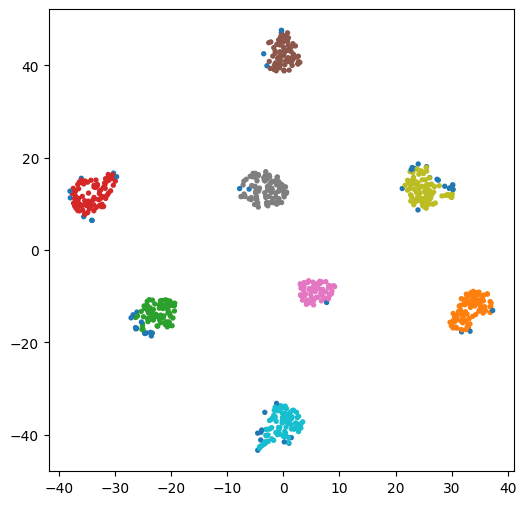

In [25]:
Z = TSNE(2,perplexity=30).fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0],Z[:,1],c=clusters,s=8,cmap="tab10")
plt.show()


In [28]:
cluster_labels = clusters   # from DBSCAN

good = cluster_labels != -1

X_good = embeddings[good]
y_good = cluster_labels[good]

print("Classifier samples:", len(y_good))


Classifier samples: 661


**Cluster Images**

Cluster 0


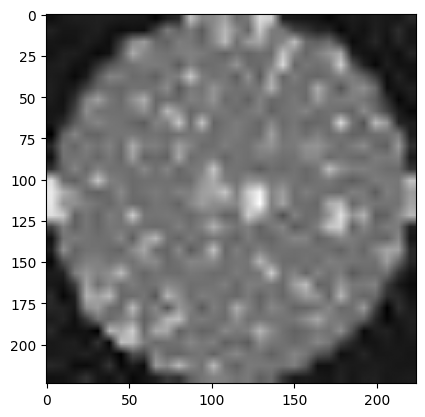

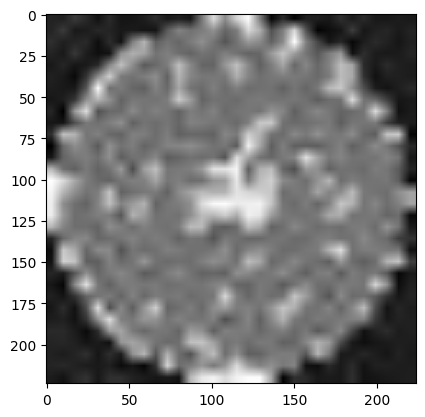

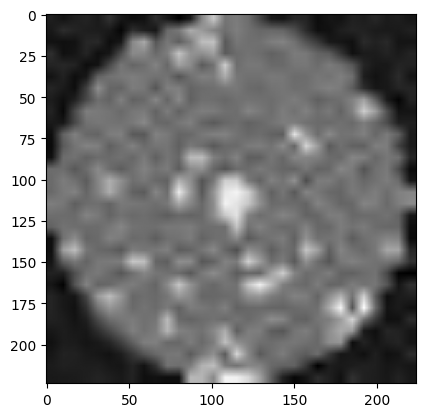

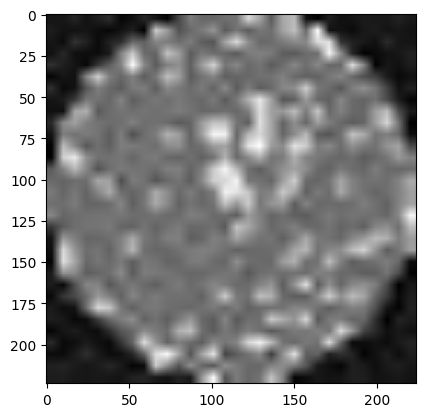

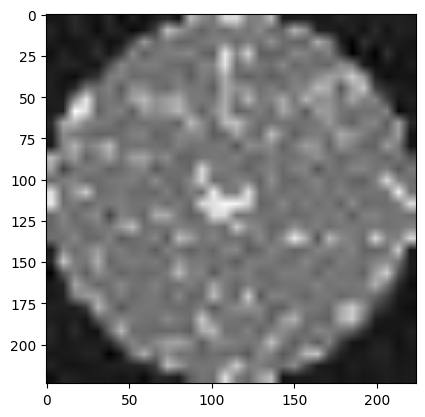

Cluster 1


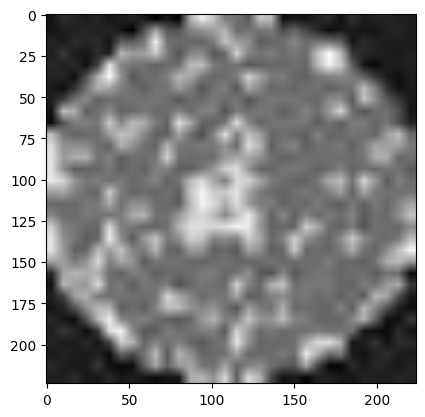

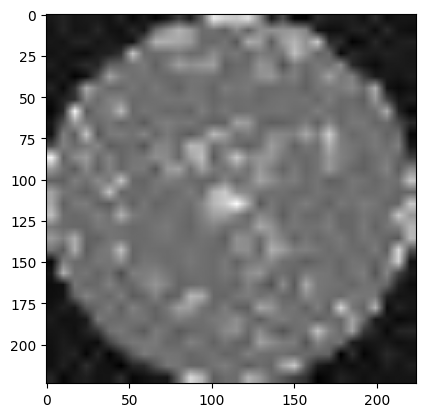

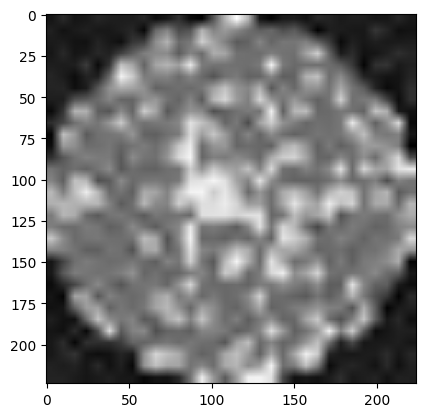

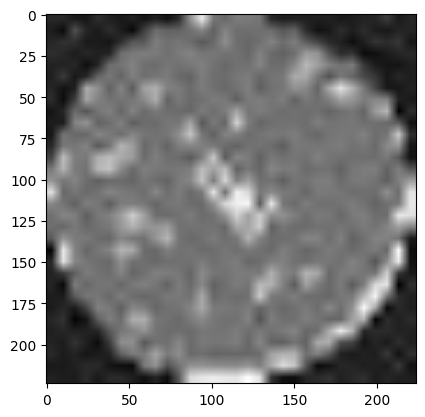

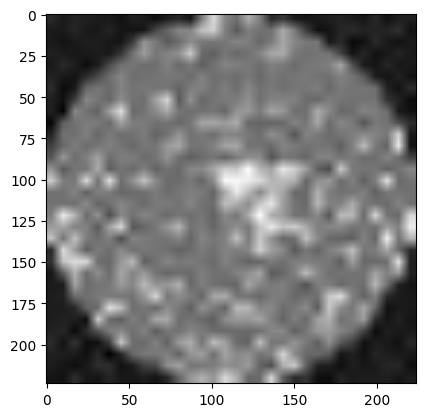

Cluster 2


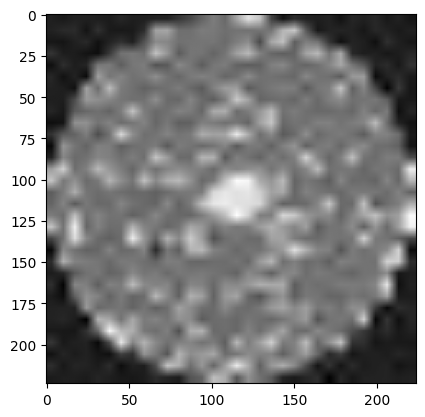

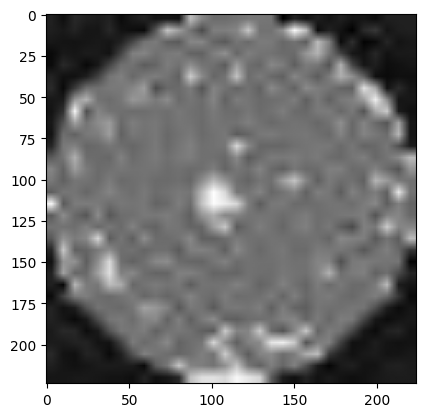

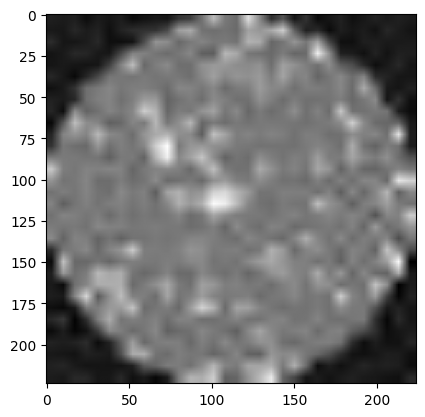

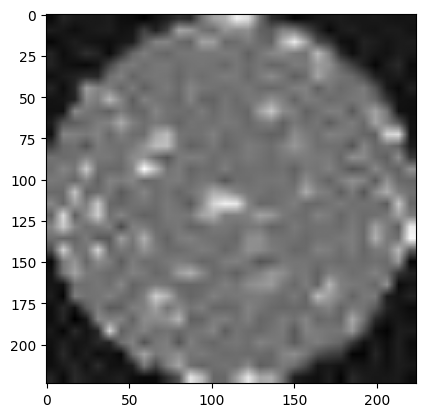

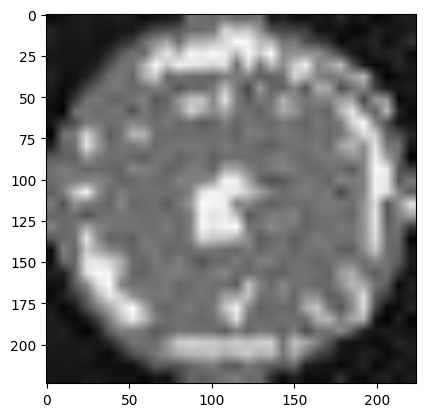

Cluster 3


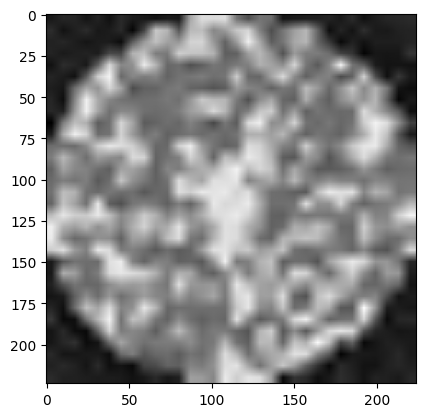

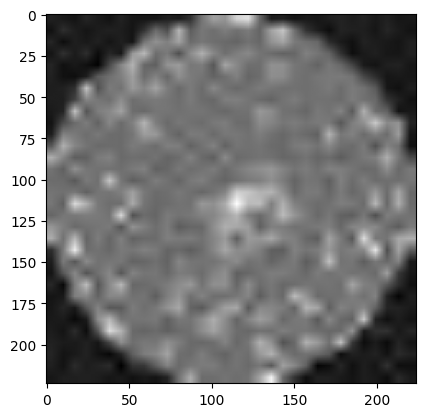

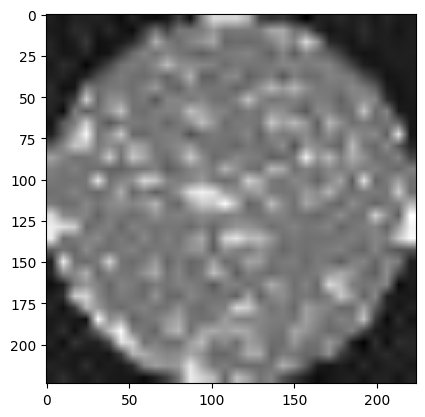

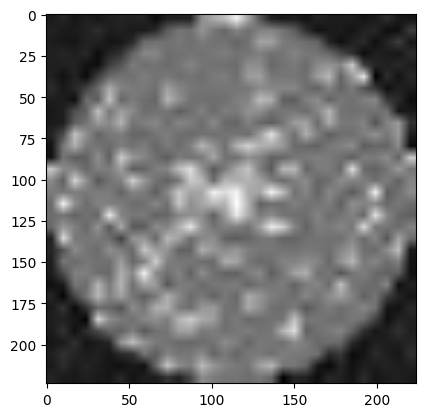

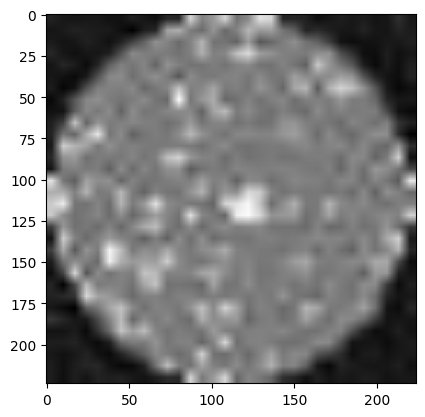

Cluster 4


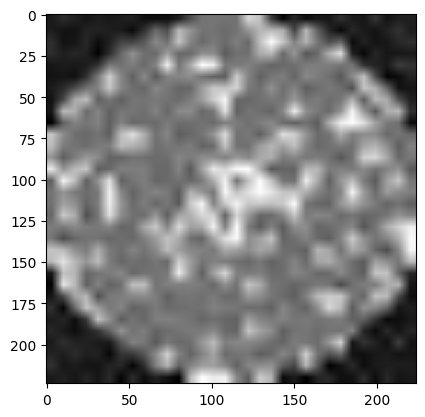

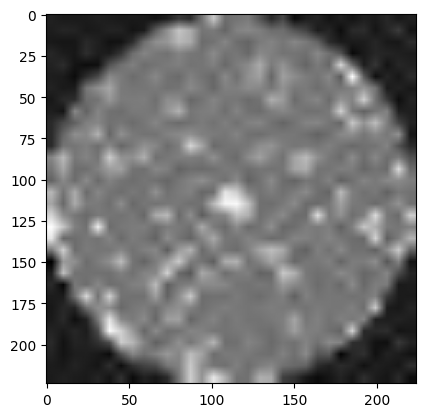

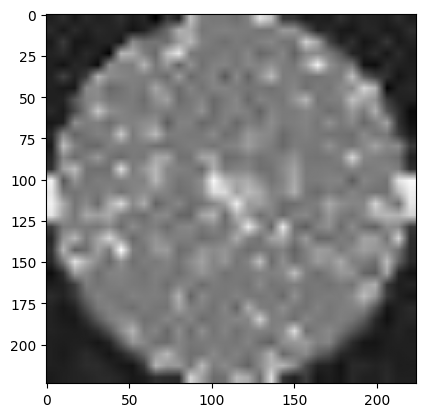

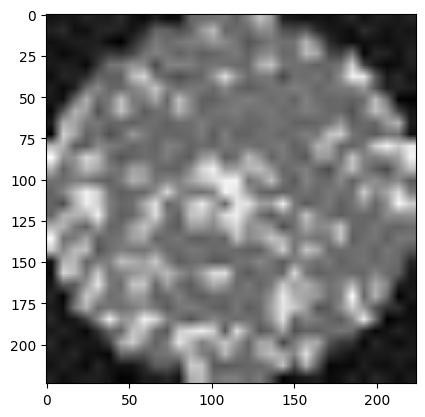

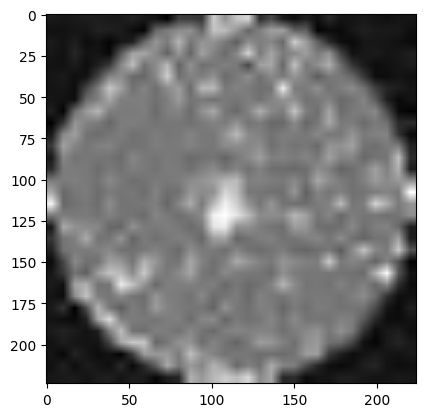

Cluster 5


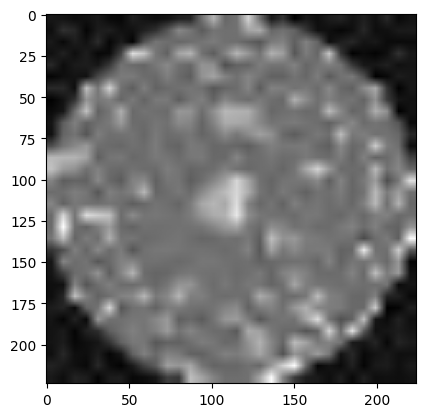

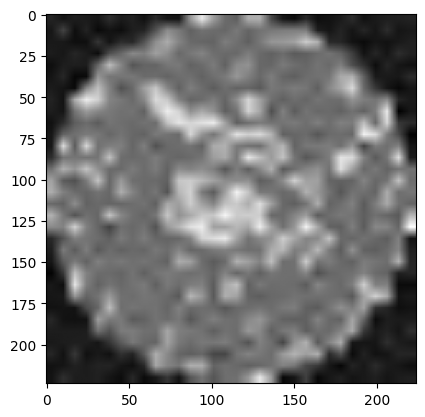

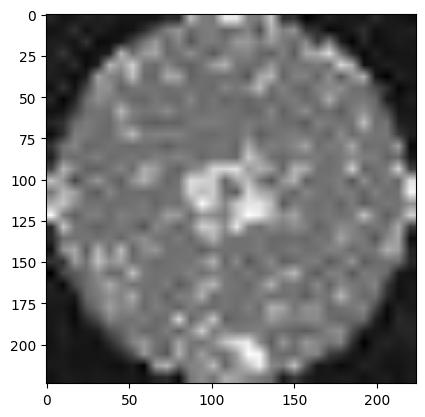

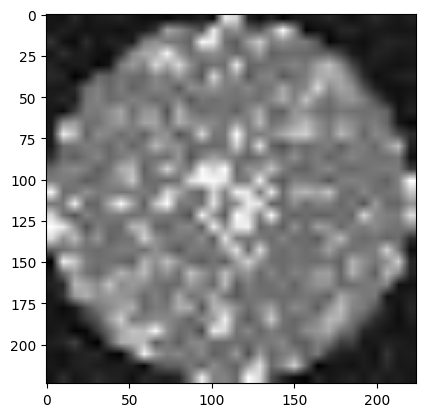

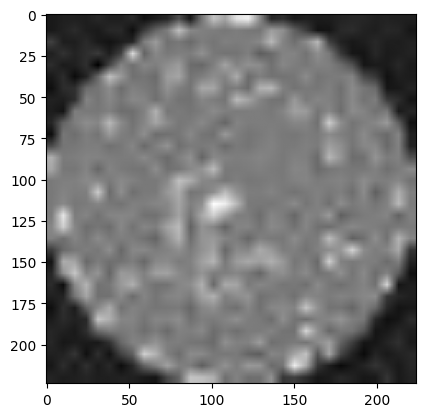

Cluster 6


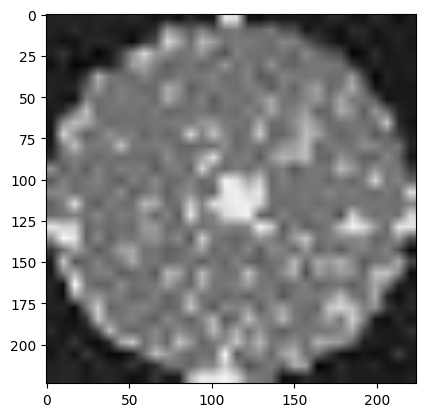

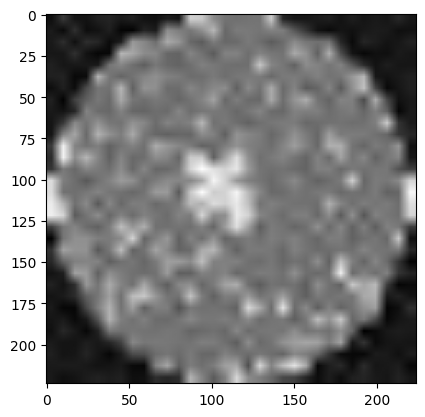

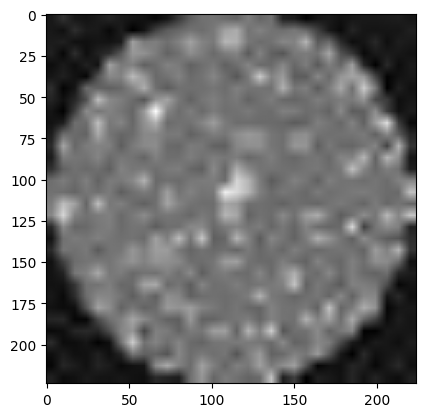

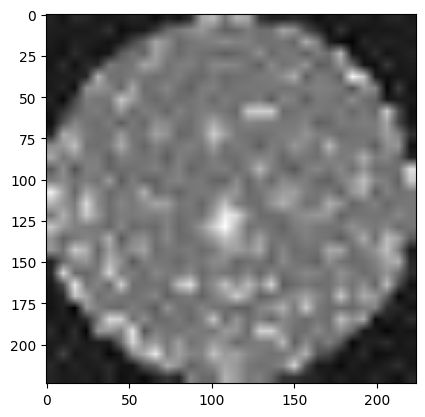

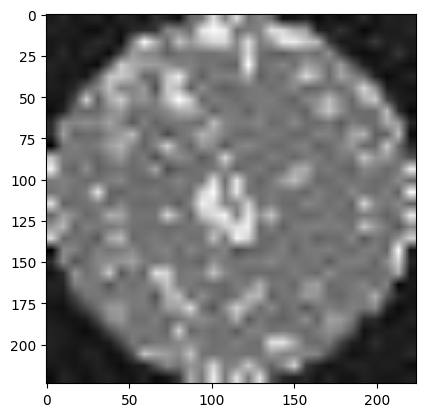

Cluster 7


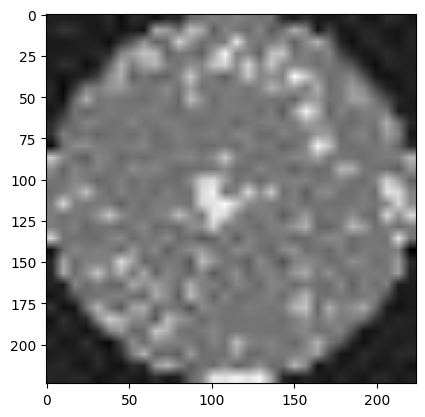

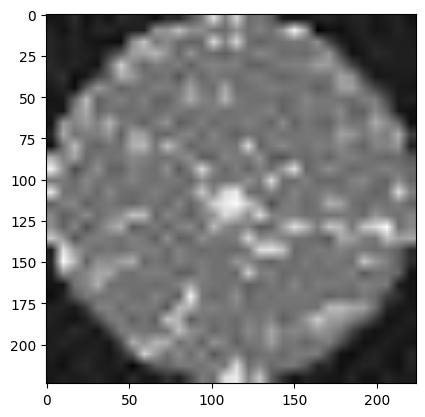

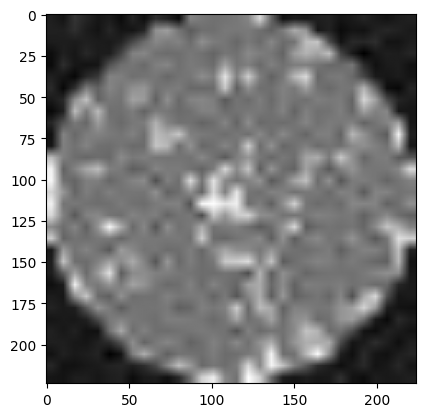

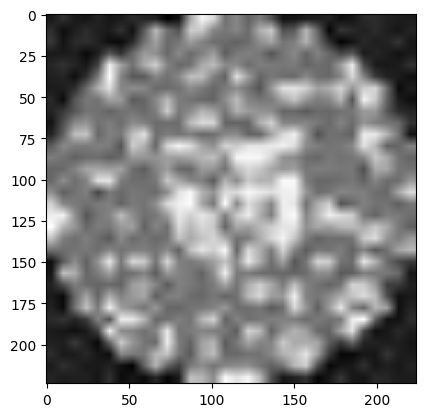

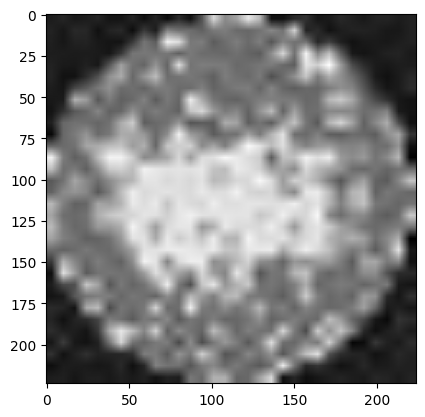

In [26]:
for cid in range(8):
    idx = np.where(clusters==cid)[0][:5]
    print("Cluster",cid)
    for i in idx:
        wafer,_ = filtered_dataset[i]
        plt.imshow(wafer[0],cmap="gray")
        plt.show()


In [30]:
y_all = clusters.copy()

K = len(np.unique(clusters[clusters!=-1]))  # number of normal clusters

y_all[y_all == -1] = K   # anomaly class index
num_classes = K + 1

print("Total classes incl anomaly:", num_classes)


Total classes incl anomaly: 9


In [35]:
print(globals().keys())


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'os', 'json', 'math', 'time', 'random', 'glob', 'Counter', 'defaultdict', 'np', 'Image', 'torch', 'nn', 'Dataset', 'DataLoader', 'transforms', 'models', 'StratifiedKFold', 'train_test_split', 'confusion_matrix', 'classification_report', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'plt', 'DBSCAN', 'rescale', 'rotate', 'opening', 'disk', 'label', 'regionprops', 'DATA_DIR', 'SAVE_DIR', '_i2', '_i3', 'CLASS_NAMES', 'CLASS_TO_IDX', 'IDX_TO_CLASS', 'WM811kDataset', '_i4', 'TRANSFORMS', 'apply_transform', 'inverse_transform', 'preprocess', 'dbscan_detect', 'multiview_masks', 'pixel_voting', 'extract_regions', 'wafer_pvm_full', 'visualize', 'make_synthetic', 'wafer', 'core', 'regions', 'conf', '_i5', 'dataset', 'lbl', '_i6', 'i', 'w', 'l', '_i7', 'tqdm', 'surv

In [36]:
X = StandardScaler().fit_transform(embeddings)


In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(embeddings)


In [41]:
model.eval()

i = np.random.randint(len(filtered_dataset))
wafer,_ = filtered_dataset[i]

with torch.no_grad():
    z = model(wafer.unsqueeze(0).to(device))
    z = scaler.transform(z.cpu().numpy())
    out = clf(torch.tensor(z).to(device))
    p = torch.softmax(out,dim=1)

pred = p.argmax().item()

if pred == K:
    print("ANOMALY")
else:
    print("Defect class:", pred)

print("Confidence:", p.max().item())


ANOMALY
Confidence: 0.7723312377929688


**All Anamaly Wafers**

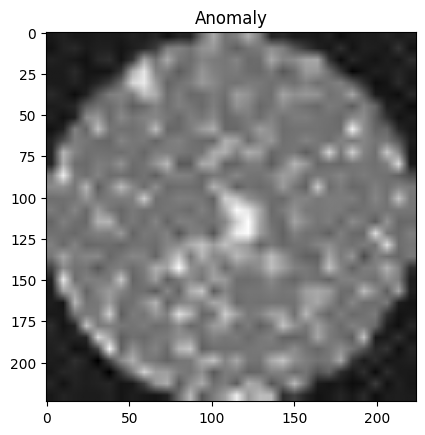

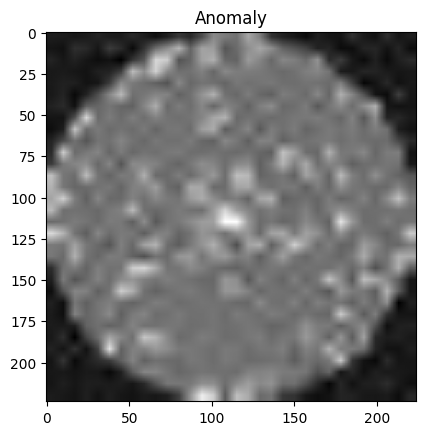

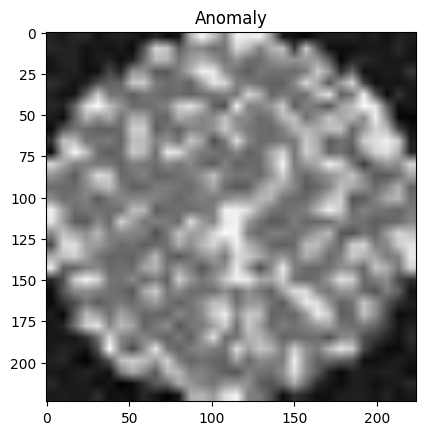

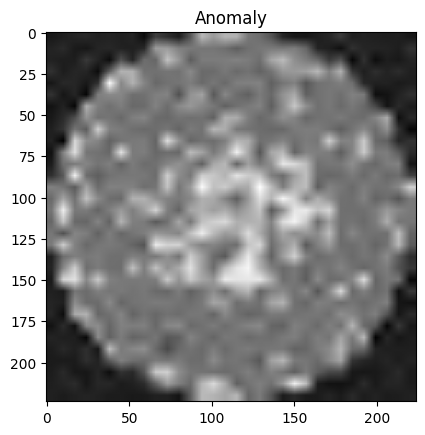

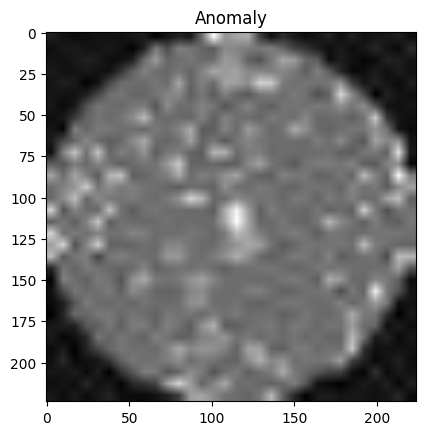

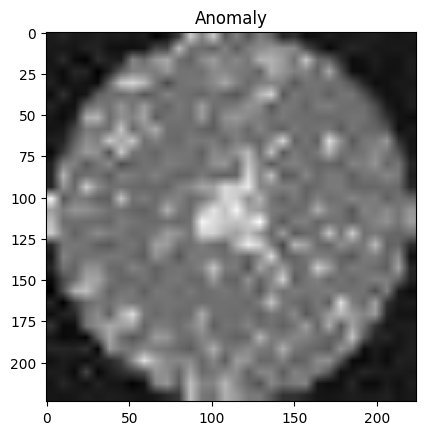

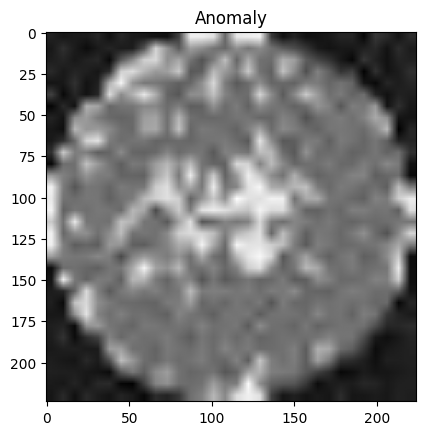

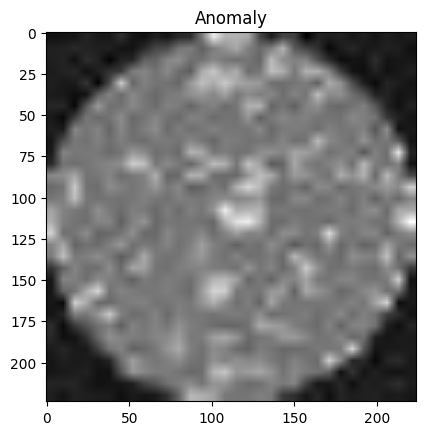

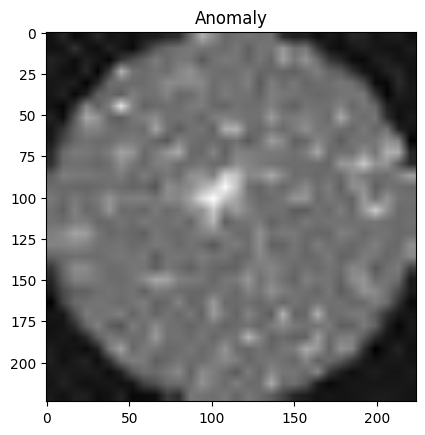

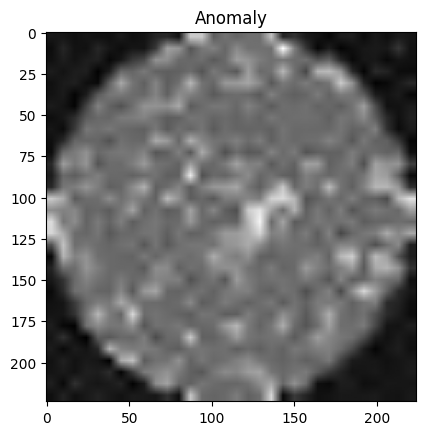

In [42]:
anom = np.where(cluster_labels==-1)[0][:10]

for i in anom:
    wafer,_ = filtered_dataset[i]
    plt.imshow(wafer[0],cmap="gray")
    plt.title("Anomaly")
    plt.show()


**Model Evaluation Based on Ground Truth**

In [46]:
cm = confusion_matrix(true, preds)

# Hungarian algorithm to maximize trace
row_ind, col_ind = linear_sum_assignment(-cm)

mapping = dict(zip(col_ind, row_ind))
print("Mapping (pred → true):", mapping)

# remap predictions
preds_remap = np.array([mapping.get(p, p) for p in preds])

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(true, preds_remap))
print("F1 macro:", f1_score(true, preds_remap, average="macro"))
print("F1 weighted:", f1_score(true, preds_remap, average="weighted"))

print(classification_report(true, preds_remap))


Mapping (pred → true): {np.int64(1): np.int64(0), np.int64(6): np.int64(1), np.int64(7): np.int64(2), np.int64(2): np.int64(3), np.int64(5): np.int64(4), np.int64(0): np.int64(5), np.int64(8): np.int64(6), np.int64(4): np.int64(7), np.int64(3): np.int64(8)}
Accuracy: 0.9388038942976356
F1 macro: 0.8617251562602677
F1 weighted: 0.9678474375158732
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        89
           1       1.00      0.86      0.93       101
           2       1.00      0.92      0.96        99
           3       1.00      0.94      0.97       100
           4       1.00      0.99      0.99        94
           5       1.00      0.99      0.99        88
           6       0.00      0.00      0.00         0
           7       1.00      0.99      0.99        67
           8       1.00      0.96      0.98        81

    accuracy                           0.94       719
   macro avg       0.89      0.84      0.86       719
we

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
